In [245]:
import models
import numpy as np
import os
import sys
import config_vmc as cv_module
from numba import jit
from scipy.linalg import schur
from copy import deepcopy
@jit(nopython=True)
def from_linearized_index(index, L, n_orbitals, n_sublattices = 2):
    orbit = index % n_orbitals
    coord = index // n_orbitals
    sublattice = coord % n_sublattices
    coord = coord // n_sublattices

    x = coord // L
    y = coord % L
    return orbit, sublattice, x, y


@jit(nopython=True)
def to_linearized_index(x, y, sublattice, orbit, L, n_orbitals, n_sublattices = 2):
    return orbit + n_orbitals * (sublattice + n_sublattices * (y + x * L))

@jit(nopython=True)
def nearest_neighbor_hexagonal(r1, r2, L):
    if r1[1] == r2[1] and r1[0] == r2[0]:
        return True, 1
    if r1[1] == r2[1] and diff_modulo(r1[0], r2[0], L, 1):
        return True, 2
    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, 1):
        return True, 3
    return False, 0

@jit(nopython=True)
def next_nearest_neighbor_hexagonal(r1, r2, L):
    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, 1):
        return True, 1

    if diff_modulo(r1[0], r2[0], L, 1) and r1[1] == r2[1]:
        return True, 2

    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, -1):
        return True, 4

    if diff_modulo(r1[0], r2[0], L, -1) and r1[1] == r2[1]:
        return True, 5

    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, -1):
        return True, 3

    if diff_modulo(r1[0], r2[0], L, -1) and diff_modulo(r1[1], r2[1], L, 1):
        return True, 6

    return False, -1


@jit(nopython=True)
def third_nearest_neighbor(r1, r2, L):
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, -1):
        return True
    if diff_modulo(r1[0], r2[0], L, 0) and diff_modulo(r1[1], r2[1], L, -1):
        return True
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, 0):
        return True
    return False


@jit(nopython=True)
def fifth_nearest_neighbor(r1, r2, L):
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, -2):
        return True
    if diff_modulo(r1[0], r2[0], L, -2) and diff_modulo(r1[1], r2[1], L, 1):
        return True
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, 1):
        return True
    return False

@jit(nopython=True)
def diff_modulo(x, y, L, d):
    if d >= 0:
        return (x - y + L) % L == d  # or (x - y + L) % L == L - d
    return (x - y + L) % L == L + d

@jit(nopython=True)
def _model_hex_2orb_Koshino(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2
    t1, t2, t5, t4 = 0.331, (-0.010 * 0. + 1.0j * 0.097 * 0.), 0 * 0.119, 0 * 0.036


    K = np.zeros((total_dof // 2, total_dof // 2)) * 1.0j
    for first in range(total_dof // 2):
        for second in range(total_dof // 2):
            orbit1, sublattice1, x1, y1 = from_linearized_index(first, Ls, n_orbitals, n_sublattices)
            orbit2, sublattice2, x2, y2 = from_linearized_index(second, Ls, n_orbitals, n_sublattices)

            r1 = np.array([x1, y1])
            r2 = np.array([x2, y2])

            if orbit1 == orbit2 and nearest_neighbor_hexagonal(r1, r2, Ls)[0] and sublattice1 == 0 and sublattice2 == 1:
                K[first, second] += t1

            if orbit2 == orbit1 and fifth_nearest_neighbor(r1, r2, Ls) and sublattice2 == sublattice1:
                K[first, second] += np.real(t2)
            if orbit2 != orbit1 and fifth_nearest_neighbor(r1, r2, Ls) and sublattice2 == sublattice1:
                if orbit1 == 0 and orbit2 == 1:
                    K[first, second] += np.imag(t2)
                else:
                    K[first, second] += -np.imag(t2)

    K = K + K.conj().T
    return K


def import_config(filename: str):
    import importlib

    module_name, extension = os.path.splitext(os.path.basename(filename))
    module_dir = os.path.dirname(filename)
    if extension != ".py":
        raise ValueError(
            "Could not import the module from {!r}: not a Python source file.".format(
                filename
            )
        )
    if not os.path.exists(filename):
        raise ValueError(
            "Could not import the module from {!r}: no such file or directory".format(
                filename
            )
        )
    sys.path.insert(0, module_dir)
    module = importlib.import_module(module_name)
    sys.path.pop(0)
    return module

@jit(nopython=True)
def get_fft(N, n_bands):
    W = np.zeros((N ** 2, N ** 2), dtype=np.complex128)
    for kx in range(N):
        for ky in range(N):
            for x in range(N):
                for y in range(N):
                    W[x * N + y, kx * N + ky] = np.exp(2.0j * np.pi / N * kx * x + 2.0j * np.pi / N * ky * y)
    return np.kron(W, np.eye(n_bands)) / N / np.sqrt(n_bands)
L = 4

@jit(nopython=True)
def fermi(energy, beta):
    return 1 / (1. + np.exp(energy * beta))

@jit(nopython=True)
def lattice_to_physical(lattice):
    x = (lattice[0] + lattice[1]) * np.sqrt(3) / 2
    y = (lattice[0] - lattice[1]) / 2

    if lattice[2] == 1:
        x += 1. / np.sqrt(3)
    return np.array([x, y])

@jit(nopython=True)
def physical_to_lattice(physical):
    x, y = physical
    lattice = [0, 0, 0]
    if np.abs(int(np.rint(2 * x.real / np.sqrt(3))) - 2 * x.real / np.sqrt(3)) >= 1e-5:
        lattice[2] = 1
        x = x - 1. / np.sqrt(3)


    lattice[1] = int(np.rint((x.real - np.sqrt(3) * y.real) / np.sqrt(3)))
    lattice[0] = int(np.rint((x.real + np.sqrt(3) * y.real) / np.sqrt(3)))

    #print(physical, lattice, (x.real + np.sqrt(3) * y.real) / np.sqrt(3), (x.real - np.sqrt(3) * y.real) / np.sqrt(3))
    return np.array(lattice)

@jit(nopython=True)
def get_C3z_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    rotation_matrix = np.array([[np.cos(2 * np.pi / 3.), np.sin(2 * np.pi / 3.)], \
                                [-np.sin(2 * np.pi / 3.), np.cos(2 * np.pi / 3.)]], dtype=np.complex128)
    rotation_matrix_orbital = np.array([[np.exp(-2.0j * np.pi / 3), 0], [0, np.exp(2.0j * np.pi / 3)]])

    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = rotation_matrix_orbital.dot(orbit_preimage_vector) #np.einsum('ij,j->i', rotation_matrix_orbital, orbit_preimage_vector)

        r_image = rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            #if coefficient != 0.:
            #    print(preindex, '-->', index)
            mapping[preindex, index] += coefficient
                
    assert np.sum(np.abs(mapping.dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping

@jit(nopython=True)
def get_C2y_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2
    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping

    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)     

        orbit_image = 1 - orbit_preimage
        coefficient = -1.0

        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)
        r_preimage -= np.array([1. / np.sqrt(3) / 2, 0.0])
        r_image = np.array([-r_preimage[0], r_preimage[1]]) + np.array([1. / np.sqrt(3) / 2, 0.0])

        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        x_image = int(np.rint(x_image)); y_image = int(np.rint(y_image))
        x_image = (x_image % Ls); y_image = (y_image % Ls)
        
        index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                           Ls, n_orbitals, n_sublattices)

        mapping[preindex, index] += coefficient

    assert np.sum(np.abs(mapping.dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_2y^2 = I
    return mapping + 0.0j

@jit(nopython=True)
def get_TRS_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2
    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping

    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)     

        orbit_image = 1 - orbit_preimage

        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)
        r_image = r_preimage

        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        x_image = int(np.rint(x_image)); y_image = int(np.rint(y_image))
        x_image = (x_image % Ls); y_image = (y_image % Ls)
        
        index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                           Ls, n_orbitals, n_sublattices)

        mapping[preindex, index] += 1

    assert np.sum(np.abs(mapping.dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_2y^2 = I
    return mapping + 0.0j


@jit(nopython=True)
def get_Tx_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = orbit_preimage_vector

        r_image = r_preimage + np.array([np.sqrt(3), 1]) / 2. #rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            mapping[preindex, index] += coefficient
                
    #assert np.sum(np.abs(mapping.dot(mapping).dot(mapping).dot(mapping).dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping

@jit(nopython=True)
def get_Ty_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = orbit_preimage_vector

        r_image = r_preimage + np.array([np.sqrt(3), -1]) / 2. #rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            mapping[preindex, index] += coefficient
                
    #assert np.sum(np.abs(mapping.dot(mapping).dot(mapping).dot(mapping).dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping

In [246]:
n_bands = 4
fft = get_fft(L, n_bands)

In [286]:
Ls = L
mapping = get_C3z_symmetry_map(L)
C2 = get_C2y_symmetry_map(L)

Tx = get_Tx_symmetry_map(L)
Ty = get_Ty_symmetry_map(L)
K0 = _model_hex_2orb_Koshino(L)
U_xy_to_chiral = np.kron(np.eye(K0.shape[0] // 2), np.array([[1, 1], [-1.0j, +1.0j]]) / np.sqrt(2))

K0 = U_xy_to_chiral.conj().T.dot(K0).dot(U_xy_to_chiral)
print(np.dot(K0.conj().flatten(), mapping.dot(K0).dot(mapping.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()))
assert np.isclose(np.dot(K0.conj().flatten(), mapping.dot(K0).dot(mapping.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
assert np.isclose(np.dot(K0.conj().flatten(), Tx.dot(K0).dot(Tx.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
assert np.isclose(np.dot(K0.conj().flatten(), Ty.dot(K0).dot(Ty.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
TRS = np.concatenate([np.array([2 * i + 1, 2 * i]) for i in range(K0.shape[0] // 2)])
assert np.allclose(K0, K0.conj().T)

K0_TRS = K0[TRS, :]
K0_TRS = K0_TRS[:, TRS].conj()

assert np.isclose(np.vdot(K0.flatten(), K0_TRS.flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1.0)
TRS = get_TRS_symmetry_map(L)

K0_plus = K0[::2, :]
K0_plus = K0_plus[:, ::2]

K0_minus = K0[1::2, :]
K0_minus = K0_minus[:, 1::2]

assert np.allclose(K0_plus, K0_minus.conj())
assert np.allclose(np.linalg.eigh(K0_plus)[0], np.linalg.eigh(K0_minus)[0])


beta = 0.01


K0 = K0 - np.diag(np.diag(K0) + 0.25)
energies = np.linalg.eigh(K0)[0]
print(energies)
### doing the FFT of K0 ###
K0_fft = fft.conj().T.dot(K0).dot(fft)
print(K0_fft[:4, :4])
K0_fft_plus = K0_fft[::2, :]
K0_fft_plus = K0_fft_plus[:, ::2]

K0_fft_minus = K0_fft[1::2, :]
K0_fft_minus = K0_fft_minus[:, 1::2]

assert np.allclose(K0_fft_plus, K0_fft_plus.conj().T)
assert np.allclose(K0_fft_minus, K0_fft_minus.conj().T)

# assert np.allclose(K0_fft_plus, K0_fft_minus.conj())
K0_check = K0_fft.copy()
for i in range(K0_check.shape[0] // n_bands):
    K0_check[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands] = 0.0
assert np.isclose(np.sum(np.abs(K0_check)), 0.0)

#print(np.unique(K0))
#print(np.unique(K0_fft))


A = np.zeros((L, L, n_bands, n_bands), dtype=np.complex128)
energies = np.zeros((L, L, n_bands), dtype=np.complex128)

energies_plus = np.zeros((L, L, n_bands // 2), dtype=np.float64)
energies_minus = np.zeros((L, L, n_bands // 2), dtype=np.float64)
for i in range(K0_check.shape[0] // n_bands):
    kx, ky = i % L, i // L
    mat = K0_fft[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands]
    assert np.allclose(mat.conj().T, mat)
    
    
    A[kx, ky, ...] = np.linalg.eigh(mat)[1]
    
    nonch = 0
    for a in range(n_bands):
        for b in range(n_bands):
            if (a + b) % 2 == 1:
                nonch += np.abs(mat[a, b])
    assert np.isclose(nonch, 0.0)
    
    
    energies[kx, ky, ...] = np.linalg.eigh(mat)[0]
    energies_plus[kx, ky, ...] = \
        np.linalg.eigh(K0_fft_plus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
                                   i * n_bands // 2:i * n_bands // 2 + n_bands // 2])[0].real
    #print(K0_fft_plus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
    #                               i * n_bands // 2:i * n_bands // 2 + n_bands // 2])
    #print(K0_fft_minus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
    #                                i * n_bands // 2:i * n_bands // 2 + n_bands // 2])
    energies_minus[kx, ky, ...] = \
        np.linalg.eigh(K0_fft_minus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
                                    i * n_bands // 2:i * n_bands // 2 + n_bands // 2])[0].real

#print(np.sort(energies.flatten()))
##print(np.sort(energies_plus.flatten()), np.sort(energies_minus.flatten()))
print(np.sort(energies_plus.flatten()) - np.sort(energies_minus.flatten()))
assert np.allclose(np.sort(energies_plus.flatten()), np.sort(energies_minus.flatten()))
@jit(nopython=True)
def get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, omega, temp):
    chi = np.zeros((n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for alpha in range(n_bands):
                for beta in range(n_bands):
                    for p in range(n_bands):
                        for q in range(n_bands):
                            for s in range(n_bands):
                                for t in range(n_bands):
                                    chi[p, q, s, t] -= A[kx, ky, s, alpha] * \
                                               np.conj(A[kx, ky, p, alpha]) * \
                                                       A_plus_q[kx, ky, q, beta] * \
                                               np.conj(A_plus_q[kx, ky, t, beta]) / \
                                                (omega + energies_plus_q[kx, ky, beta] - energies[kx, ky, alpha] + 1e-10j) * \
                                                (fermi(energies_plus_q[kx, ky, beta], temp) - fermi(energies[kx, ky, alpha], temp))

    return chi / n_bands / Ls ** 2

susc_0 = np.zeros((L, L, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
for qx in range(Ls):
    for qy in range(Ls):
        A_plus_q = np.roll(A, shift = qx, axis=0) 
        A_plus_q = np.roll(A_plus_q, shift = qy, axis=1)
    
        energies_plus_q = np.roll(energies, shift = qx, axis=0)
        energies_plus_q = np.roll(energies_plus_q, shift = qy, axis=1)
        susc_0[qx, qy, ...] = get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, 0., beta)
        
        for a in range(n_bands):
            for b in range(n_bands):
                for c in range(n_bands):
                    for d in range(n_bands):
                        if (a + d) % 2 != (b + c) % 2:
                            assert np.isclose(susc_0[qx, qy, a, b, c, d], 0.0)
                        
susc_uniform = np.sum(susc_0[:, :, np.arange(n_bands), np.arange(n_bands), :, :], axis=2)
susc_uniform = np.sum(susc_uniform[:, :, np.arange(n_bands), np.arange(n_bands)], axis=-1).real
#print(np.sum(np.abs(A.real)))




vol = Ls ** 2 * n_bands

susc0_full = np.zeros((vol, vol, vol, vol), dtype=np.complex128)

for i in range(Ls ** 2):
    susc0_full[i * n_bands : i * n_bands + n_bands, \
                i * n_bands : i * n_bands + n_bands, \
                i * n_bands : i * n_bands + n_bands, \
                i * n_bands : i * n_bands + n_bands] = \
            susc_0[i // Ls, i % Ls, ...].reshape((n_bands, n_bands, n_bands, n_bands))

susc0_realspace = np.einsum('abcd,ai->ibcd', susc0_full, fft)
susc0_realspace = np.einsum('ibcd,bj->ijcd', susc0_realspace, fft.conj())
susc0_realspace = np.einsum('ijcd,ck->ijkd', susc0_realspace, fft.conj())
susc0_realspace = np.einsum('ijkd,dl->ijkl', susc0_realspace, fft)

susc0_realspace_C3 = np.einsum('abcd,ai->ibcd', susc0_realspace, mapping)
susc0_realspace_C3 = np.einsum('ibcd,bj->ijcd', susc0_realspace_C3, mapping.conj())
susc0_realspace_C3 = np.einsum('ijcd,ck->ijkd', susc0_realspace_C3, mapping.conj())
susc0_realspace_C3 = np.einsum('ijkd,dl->ijkl', susc0_realspace_C3, mapping)

print(np.vdot(susc0_realspace.flatten(), susc0_realspace_C3.flatten()) / np.vdot(susc0_realspace.flatten(), susc0_realspace.flatten()))


(0.9999999999999994+0j)
[-1.243     -1.243     -0.9901385 -0.9901385 -0.9901385 -0.9901385
 -0.9901385 -0.9901385 -0.9901385 -0.9901385 -0.9901385 -0.9901385
 -0.9901385 -0.9901385 -0.581     -0.581     -0.581     -0.581
 -0.581     -0.581     -0.581     -0.581     -0.581     -0.581
 -0.581     -0.581     -0.581     -0.581     -0.581     -0.581
 -0.581     -0.581      0.081      0.081      0.081      0.081
  0.081      0.081      0.081      0.081      0.081      0.081
  0.081      0.081      0.081      0.081      0.081      0.081
  0.081      0.081      0.4901385  0.4901385  0.4901385  0.4901385
  0.4901385  0.4901385  0.4901385  0.4901385  0.4901385  0.4901385
  0.4901385  0.4901385  0.743      0.743    ]
[[-0.0625 +0.j  0.     +0.j  0.24825+0.j  0.     +0.j]
 [ 0.     +0.j -0.0625 +0.j  0.     +0.j  0.24825+0.j]
 [ 0.24825+0.j  0.     +0.j -0.0625 +0.j  0.     +0.j]
 [ 0.     +0.j  0.24825+0.j  0.     +0.j -0.0625 +0.j]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

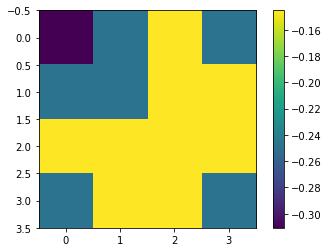

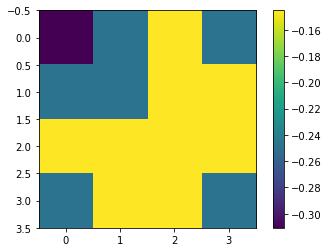

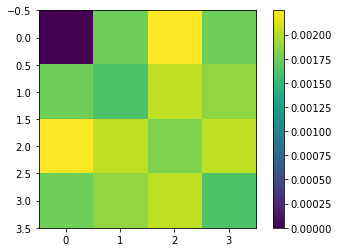

-3.1032077508286458

In [281]:
import matplotlib.pyplot as plt
plt.imshow(energies_plus[..., 0].real, interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(energies_minus[..., 0].real, interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(susc_uniform, interpolation='nearest')
plt.colorbar()
plt.show()


np.sum(energies_minus[..., 0].real)

In [282]:
Alat = np.array([[np.sqrt(3) / 2., 1. / 2.], [np.sqrt(3) / 2., -1. / 2.]])
G = 2 * np.pi * np.array([[1. / np.sqrt(3), +1], [1. / np.sqrt(3), -1.]])  # is this momentum compatible?

print(Alat.dot(G) /2 / np.pi)

def get_interaction(n_bands, qx, qy, U, J):
    # k -- z1, q -- z2
    U_total = np.zeros((2 * n_bands, 2 * n_bands, 2 * n_bands, 2 * n_bands), dtype=np.complex128)
    
    q_phys = (G[0] * (qx) + G[1] * (qy)) / L
    exp_q1_pp = np.exp(1.0j * np.dot(q_phys, Alat[0]))
    exp_q2_pp = np.exp(1.0j * np.dot(q_phys, Alat[1]))
    
    q_phys = (G[0] * (-qx) + G[1] * (-qy)) / L
    exp_q1_mm = np.exp(1.0j * np.dot(q_phys, Alat[0]))
    exp_q2_mm = np.exp(1.0j * np.dot(q_phys, Alat[1]))
    
    AB_factor_pp = (1. + exp_q1_pp + exp_q2_pp) / 2
    #AB_factor_pm = (1. + exp_q1_pm + exp_q2_pm) / 2
    #AB_factor_mp = (1. + exp_q1_mp + exp_q2_mp) / 2
    AB_factor_mm = (1. + exp_q1_mm + exp_q2_mm) / 2
    
    BA_factor_pp = np.conj(AB_factor_pp)
    #BA_factor_pm = np.conj(AB_factor_pm)
    #BA_factor_mp = np.conj(AB_factor_mp)
    BA_factor_mm = np.conj(AB_factor_mm)
    
    #print(exp_q1, exp_q2)


    for band in range(4):
        U_total[band, band, band + 4, band + 4] += -U
        U_total[band + 4, band, band + 4, band] += +U
        U_total[band, band + 4, band, band + 4] += +U
        U_total[band + 4, band + 4, band, band] += -U
        
    for band in range(4):
        U_total[band + 4, band + 4, band, band] += -U
        U_total[band, band + 4, band, band + 4] += +U
        U_total[band + 4, band, band + 4, band] += +U
        U_total[band, band, band + 4, band + 4] += -U

    for subl in range(2):
        for nu in range(2):
            nubar = 1 - nu
            band = subl * 2 + nu
            bandbar = subl * 2 + nubar
            
            for s in range(2):
                for sbar in range(2):
                    U_total[band + 4 * s, band + 4 * s, bandbar + 4 * sbar, bandbar + 4 * sbar] += -U
                    U_total[bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar, band + 4 * s] += +U
                    U_total[band + 4 * s, bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar] += +U
                    U_total[bandbar + 4 * sbar, bandbar + 4 * sbar, band + 4 * s, band + 4 * s] += -U

    
    for nuA in range(2):
        for nuB in range(2):
            for sA in range(2):
                for sB in range(2):
                    U_total[0 * 2 + nuA + 4 * sA, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuB + 4 * sB] = -J * AB_factor_pp
                    #U_total[1 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA] = +J * AB_factor_pm
                    #U_total[0 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB] = +J * AB_factor_mp
                    U_total[1 * 2 + nuB + 4 * sB, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuA + 4 * sA] = -J * AB_factor_mm
                    
                    U_total[1 * 2 + nuA + 4 * sA, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuB + 4 * sB] = -J * BA_factor_pp
                    #U_total[0 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA] = +J * BA_factor_pm
                    #U_total[1 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB] = +J * BA_factor_mp
                    U_total[0 * 2 + nuB + 4 * sB, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuA + 4 * sA] = -J * BA_factor_mm   
                    
    #assert np.allclose(U_total, U_total.transpose((3, 2, 1, 0)).conj())    
    return U_total


U_s = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
U_c = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
U_t = np.zeros((Ls, Ls, 2 * n_bands, 2 * n_bands, 2 * n_bands, 2 * n_bands), dtype=np.complex128)

chi_s = np.zeros((Ls, Ls, Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
chi_c = np.zeros((Ls, Ls, Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)


U = 1000
J = 0.0
for qx in range(Ls):
    for qy in range(Ls):
        inter = get_interaction(n_bands, qx, qy, U, J)
        #print(inter - inter.transpose((3, 2, 1, 0)).conj(), qx, qy)
        #print('---')
        U_s[qx, qy, ...] = inter[:4, :4, :4, :4] - inter[:4, :4, 4:, 4:]
        U_c[qx, qy, ...] = -inter[:4, :4, :4, :4] - inter[:4, :4, 4:, 4:]
        U_t[qx, qy, ...] = inter

        #chi_s[kx, ky, qx, qy, ...] = (np.linalg.inv(np.eye(n_bands ** 2) - susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
        #chi_c[kx, ky, qx, qy, ...] = (np.linalg.inv(np.eye(n_bands ** 2) + susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))

        #for a in range(4):
        #    for b in range(4):
        #        for c in range(4):
        #            for d in range(4):
        #                if (a + c) % 2 != (b + d) %2:
        #                    assert np.isclose(chi_c[qx, qy, a, b, c, d], 0.0)
        #                    assert np.isclose(chi_s[qx, qy, a, b, c, d], 0.0)
        # after interaction account, still converve valley number

#for qx in range(Ls):
#    for qy in range(Ls):
#        assert np.allclose(U_t[qx, qy], U_t[-qx, -qy].transpose((3, 2, 1, 0)).conj())

        
green = np.zeros((Ls, Ls, n_bands, n_bands), dtype=np.complex128)

for kx in range(Ls):
    for ky in range(Ls):
        for a in range(n_bands):
            for b in range(n_bands):
                for band in range(n_bands):
                    green[kx, ky, a, b] += A[kx, ky, a, band] * \
                                   np.conj(A[kx, ky, b, band]) / \
                                  (-energies[kx, ky, band].real)
                if (a + b) % 2 == 1:
                    #print(green[kx, ky, a, b])
                    assert np.isclose(green[kx, ky, a, b], 0.)
#print(U_c[0, 0, :2, :2, :2, :2].reshape((4, 4)))

[[0.78867513 0.3660254 ]
 [0.21132487 1.3660254 ]]


In [284]:
Gsinglet = np.zeros((Ls, Ls, Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)

#for qx in range(Ls):
#    for qy in range(Ls):
#        for kx in range(Ls):
#            for ky in range(Ls):
#                Gsinglet[kx, ky, qx, qy, ...] = (0 * 3. / 2. * U_s[kx, ky, qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_s[kx, ky, qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) + \
#                                         U_s[kx, ky, qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) / 2. + \
#                                         U_c[kx, ky, qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) / 2. - \
#                                         0 * 1. / 2. * U_c[kx, ky, qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_c[kx, ky, qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
print(U_s.shape)
sh = (n_bands ** 2, n_bands ** 2)
sh2 = (n_bands, n_bands, n_bands, n_bands, )
for qx in range(Ls):
    for qy in range(Ls):
        for kx in range(Ls):
            for ky in range(Ls):
                Gsinglet[kx, ky, qx, qy, ...] = \
                                         U_s[(qx + kx) % Ls, (qy + ky) % Ls, ...] / 4. + \
                                         U_c[(qx + kx) % Ls, (qy + ky) % Ls, ...] / 4. + \
                                         U_s[qx - kx, qy - ky, ...].transpose((0, 2, 1, 3)) / 4. + \
                                         U_c[qx - kx, qy - ky, ...].transpose((0, 2, 1, 3)) / 4. + \
                3. / 4. * (U_s[(qx + kx) % Ls, (qy + ky) % Ls, ...].reshape(sh) @ susc_0[(qx + kx) % Ls, (qy + ky) % Ls, ...].reshape(sh) @ U_s[(qx + kx) % Ls, (qy + ky) % Ls, ...].reshape(sh)).reshape(sh2) - \
                1. / 4. * (U_c[(qx + kx) % Ls, (qy + ky) % Ls, ...].reshape(sh) @ susc_0[(qx + kx) % Ls, (qy + ky) % Ls, ...].reshape(sh) @ U_c[(qx + kx) % Ls, (qy + ky) % Ls, ...].reshape(sh)).reshape(sh2) + \
                3. / 4. * (U_s[qx - kx, qy - ky, ...].reshape(sh) @ susc_0[qx - kx, qy - ky, ...].reshape(sh) @ U_s[qx - kx, qy - ky, ...].reshape(sh)).reshape(sh2).transpose((0, 2, 1, 3)) - \
                1. / 4. * (U_c[qx - kx, qy - ky, ...].reshape(sh) @ susc_0[qx - kx, qy - ky, ...].reshape(sh) @ U_c[qx - kx, qy - ky, ...].reshape(sh)).reshape(sh2).transpose((0, 2, 1, 3))


                
Gsinglet_s = Gsinglet[:, :, ::-1, ...]
Gsinglet_s = Gsinglet_s[:, :, :, ::-1, ...]
Gsinglet_s = Gsinglet_s.transpose((0, 1, 2, 3, 7, 5, 6, 4))

print(np.vdot(Gsinglet.flatten(), Gsinglet_s.flatten()) / np.vdot(Gsinglet.flatten(), Gsinglet.flatten()))
                
@jit(nopython=True)
def construct_op(Ls, n_bands, Gsinglet, beta, green):
    op = np.zeros((Ls, Ls, Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    op_singletized = np.zeros((Ls, Ls, Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for qx in range(Ls):
                for qy in range(Ls):
                    for abar in range(n_bands):
                        for bbar in range(n_bands):
                            for cbar in range(n_bands):
                                for dbar in range(n_bands):
                                    for a in range(n_bands):
                                        for b in range(n_bands):
                                            op[kx, ky, qx, qy, abar, bbar, cbar, dbar] -= 1. / Ls ** 2 / beta * \
                                                   Gsinglet[kx, ky, qx, qy, a, abar, bbar, b] * \
                                                   green[qx, qy, a, cbar] * \
                                                   green[-qx, -qy, b, dbar] # FIXME --> need conj?#np.conj(green[(-qx) % Ls, (-qy) % Ls, b, dbar])
                                            op_singletized[kx, ky, -qx, -qy, abar, bbar, dbar, cbar] -= 1. / Ls ** 2 / beta * \
                                                   Gsinglet[kx, ky, qx, qy, a, abar, bbar, b] * \
                                                   green[qx, qy, a, cbar] * \
                                                   green[-qx, -qy, b, dbar] # FIXME --> need conj?#np.conj(green[(-qx) % Ls, (-qy) % Ls, b, dbar])
    return op, op_singletized


op, op_singletized = construct_op(Ls, n_bands, Gsinglet, beta, green)

#op = op + op_singletized
op = op.transpose((0, 1, 4, 5, 2, 3, 6, 7)).reshape((Ls ** 2 * n_bands ** 2, Ls ** 2 * n_bands ** 2))

#for kx in range(Ls):
#    for ky in range(Ls):
#        assert np.allclose(op[kx, ky, ...], op[0, 0, ...])

op_singletized = op_singletized.transpose((0, 1, 4, 5, 2, 3, 6, 7)).reshape((Ls ** 2 * n_bands ** 2, Ls ** 2 * n_bands ** 2))
vol = Ls ** 2 * n_bands


op_full = np.zeros((vol, vol, vol, vol), dtype=np.complex128)
op_singletized_full = np.zeros((vol, vol, vol, vol), dtype=np.complex128)
for i in range(Ls ** 2):
    for j in range(Ls ** 2):
        op_full[i * n_bands : i * n_bands + n_bands, \
                i * n_bands : i * n_bands + n_bands, \
                j * n_bands : j * n_bands + n_bands, \
                j * n_bands : j * n_bands + n_bands] = \
            op[n_bands ** 2 * i:n_bands ** 2 * i + n_bands ** 2, \
               n_bands ** 2 * j:n_bands ** 2 * j + n_bands ** 2].reshape((n_bands, n_bands, n_bands, n_bands))
        op_singletized_full[i * n_bands : i * n_bands + n_bands, \
                i * n_bands : i * n_bands + n_bands, \
                j * n_bands : j * n_bands + n_bands, \
                j * n_bands : j * n_bands + n_bands] = \
            op_singletized[n_bands ** 2 * i:n_bands ** 2 * i + n_bands ** 2, \
               n_bands ** 2 * j:n_bands ** 2 * j + n_bands ** 2].reshape((n_bands, n_bands, n_bands, n_bands))

op_realspace = np.einsum('abcd,ai->ibcd', op_full, fft)
op_realspace = np.einsum('ibcd,bj->ijcd', op_realspace, fft.conj())
op_realspace = np.einsum('ijcd,ck->ijkd', op_realspace, fft.conj())
op_realspace = np.einsum('ijkd,dl->ijkl', op_realspace, fft)


op_realspace_C3 = np.einsum('abcd,ai->ibcd', op_realspace, mapping.conj())
op_realspace_C3 = np.einsum('ibcd,bj->ijcd', op_realspace_C3, mapping.conj())
op_realspace_C3 = np.einsum('ijcd,ck->ijkd', op_realspace_C3, mapping)
op_realspace_C3 = np.einsum('ijkd,dl->ijkl', op_realspace_C3, mapping)
print(np.vdot(op_realspace.flatten(), op_realspace_C3.flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))

op_singletized_realspace_C3 = np.einsum('abcd,ai->ibcd', op_singletized_realspace, mapping.conj())
op_singletized_realspace_C3 = np.einsum('ibcd,bj->ijcd', op_singletized_realspace_C3, mapping.conj())
op_singletized_realspace_C3 = np.einsum('ijcd,ck->ijkd', op_singletized_realspace_C3, mapping)
op_singletized_realspace_C3 = np.einsum('ijkd,dl->ijkl', op_singletized_realspace_C3, mapping)
print(np.vdot(op_singletized_realspace.flatten(), op_singletized_realspace_C3.flatten()) / np.vdot(op_singletized_realspace.flatten(), op_singletized_realspace.flatten()))



op_realspace_TRS = np.einsum('abcd,ai->ibcd', op_realspace, TRS.conj())
op_realspace_TRS = np.einsum('ibcd,bj->ijcd', op_realspace_TRS, TRS.conj())
op_realspace_TRS = np.einsum('ijcd,ck->ijkd', op_realspace_TRS, TRS)
op_realspace_TRS = np.einsum('ijkd,dl->ijkl', op_realspace_TRS, TRS)
print(np.vdot(op_realspace.flatten(), op_realspace_TRS.conj().flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))



op_singletized_realspace = np.einsum('abcd,ai->ibcd', op_singletized_full, fft)
op_singletized_realspace = np.einsum('ibcd,bj->ijcd', op_singletized_realspace, fft.conj())
op_singletized_realspace = np.einsum('ijcd,ck->ijkd', op_singletized_realspace, fft.conj())
op_singletized_realspace = np.einsum('ijkd,dl->ijkl', op_singletized_realspace, fft)

#op_realspace_Tx = np.einsum('abcd,ai->ibcd', op_realspace, Tx.conj())
#op_realspace_Tx = np.einsum('ibcd,bj->ijcd', op_realspace_Tx, Tx.conj())
#op_realspace_Tx = np.einsum('ijcd,ck->ijkd', op_realspace_Tx, Tx)
#op_realspace_Tx = np.einsum('ijkd,dl->ijkl', op_realspace_Tx, Tx)

print(np.vdot(op_realspace.flatten(), op_singletized_realspace.flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))

#print(np.vdot(op_realspace.flatten(), op_realspace_Tx.flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))



#op_realspace = np.einsum('abcd,ai,bj,ck,dl->ijkl', op_full, fft, fft.conj().T, fft, fft.conj().T)


(4, 4, 4, 4, 4, 4)
(1+0j)
(1.0000000000000002+3.151818075161887e-19j)


KeyboardInterrupt: 

In [241]:
#print(np.vdot(op_realspace.flatten(), op_realspace.transpose((1, 0, 2, 3)).flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))
#print(np.vdot(op_realspace.flatten(), op_realspace.transpose((0, 1, 3, 2)).flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))

In [242]:
#print(np.unique(op))

from scipy.sparse.linalg import eigsh, eigs

#op_realspace = op_realspace.reshape((vol ** 2, vol ** 2))
E, eig = np.linalg.eig(op)#eigs(op, k=6, which='LR', maxiter=100000)

#E, eig = eigs(op_realspace, k=40, which='LR', maxiter=10000)#, tol=1e-10)
#E, eig = eigs(op, k=20, which='LR', maxiter=10000000)#, tol=1e-10)
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q


#for e, vec in zip(E, eig.T):
#    assert np.allclose(op.dot(vec), e * vec)
#print(np.sort(-E.real) * -1)
eig = eig[:, np.argsort(-E.real)]
E = E[np.argsort(-E.real)]
print(E.real[:100])

eig = gram_schmidt_columns(eig)

print(np.vdot(eig[:, 0], eig[:, 1]))

[6.82154141e+04 6.82154141e+04 4.53459965e-10 3.75513536e-10
 2.01470627e-10 1.90330345e-10 1.38386851e-10 1.32171193e-10
 9.90127504e-11 9.84146385e-11 9.30758552e-11 8.91884679e-11
 7.26504723e-11 7.25901279e-11 6.51158536e-11 6.27006178e-11
 5.55483573e-11 4.81988876e-11 4.13077791e-11 3.70727121e-11
 3.21385875e-11 3.20028463e-11 3.08903378e-11 2.55389213e-11
 2.49218719e-11 2.01135596e-11 1.75762630e-11 1.70134395e-11
 1.69560868e-11 1.62685062e-11 1.62515147e-11 1.44077762e-11
 1.33727070e-11 1.33282496e-11 1.04709319e-11 9.03076553e-12
 9.00410263e-12 8.06294066e-12 7.71904331e-12 7.29043396e-12
 6.52750758e-12 5.93419661e-12 5.93085967e-12 5.60842857e-12
 4.22510863e-12 4.17739521e-12 4.09982793e-12 4.08219383e-12
 3.85891568e-12 3.53338702e-12 3.47107089e-12 3.40057757e-12
 2.94130173e-12 2.93508967e-12 2.81459479e-12 2.81145800e-12
 2.61788836e-12 2.48257460e-12 2.36845345e-12 2.30333680e-12
 2.12044403e-12 2.06326952e-12 1.91238618e-12 1.83028478e-12
 1.71769357e-12 1.688001

1.0


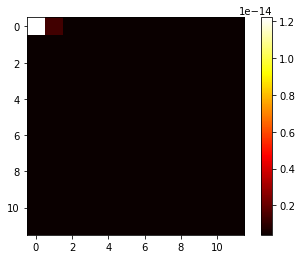

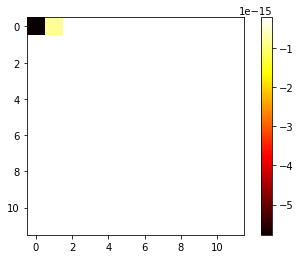

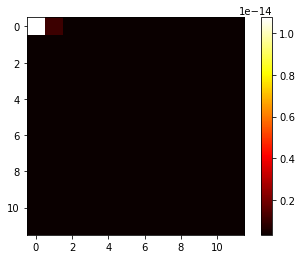

In [243]:
vec = eig[:, 0].reshape((Ls, Ls, n_bands, n_bands))[..., 0, 0].flatten()
import matplotlib.pyplot as plt

maxelem = 1.#vec[np.argmax(np.abs(vec))]
print(maxelem)
plt.imshow(np.abs(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.real(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.imag(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [244]:
vals = []
c2vals = []
trsvals = []

#mapping = mapping.conj()
gaps_realspace = []
for j in range(len(E)):
    if np.abs(E[j]) < 1e-6:
        vals.append(0.)
        c2vals.append(0.)
        trsvals.append(0.)
        continue
    vec = eig[:, j].reshape((Ls ** 2, n_bands, n_bands))
    
    gap_matrix = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)
    gap_matrix_TRS = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)
    for i in range(Ls ** 2):
        gap_matrix[i * n_bands:i * n_bands + n_bands, \
                   i * n_bands:i * n_bands + n_bands] = vec[i, ...]
        kx = i // Ls
        ky = i % Ls
        
        kx = (-kx) % Ls
        ky = (-ky) % Ls
        
        ip = kx * Ls + ky
        gap_matrix_TRS[i * n_bands:i * n_bands + n_bands, \
                       i * n_bands:i * n_bands + n_bands] = vec[ip, ...].conj()
    #    #print(i, vec[i, ...]);# print(vec[0, ...])
    #    #assert np.allclose(vec[i, ...], vec[0, ...])

    gap_relspace = fft.dot(gap_matrix).dot(fft.conj().T)
    print('nonsinglet:', np.vdot(gap_relspace.flatten(), gap_relspace.T.flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    
    
    #for i in range(1, 2):
    #    print(repr(gap_relspace[4 * i:4 * i + 4, 4 * i + 0:4 * i + 4]))
    #gap_relspace = (gap_relspace + gap_relspace.T) / 2.
    # assert np.allclose(gap_relspace, gap_relspace.T)
    gap_relspace_TRS = fft.conj().dot(gap_matrix.conj()).dot(fft.T)
    gap_relspace_TRS_true = fft.dot(gap_matrix_TRS).dot(fft.conj().T)
    assert np.allclose(gap_relspace_TRS, gap_relspace_TRS_true)
    
    if False:# j == 0:
        for a in range(vol):
            for b in range(vol):
                atrs = (a // 2) * 2 + (1 - a % 2)
                btrs = (b // 2) * 2 + (1 - b % 2)
                
                #print(a, b, np.abs(gap_relspace[a, b] - gap_relspace[atrs, btrs]) < 1e-10)
                if np.abs(gap_relspace[b, a] - gap_relspace[atrs, btrs]) >1e-10:
                    print(a, b, gap_relspace[b, a] / gap_relspace[atrs, btrs])
    gaps_realspace.append(gap_relspace * 1.)
    #gap_relspace = vec.reshape((vol, vol))
    #print(gap_relspace[:4, :4])
    #print(gap_relspace[:4, :4] / (mapping.dot(gap_relspace).dot(mapping.T)[:4, :4] + 1e-10))
    #print(np.vdot(gap_relspace_TRS.flatten(), gap_relspace_TRS.flatten()) * 16.)
    #assert np.isclose(np.vdot(gap_relspace.flatten(), gap_relspace.flatten()) * 16., 1.0)
    assert np.isclose(np.vdot(gap_relspace_TRS.flatten(), gap_relspace_TRS.flatten()) * 16., 1.0)
    
    vals.append(np.vdot(gap_relspace.flatten(), mapping.dot(gap_relspace).dot(mapping.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    c2vals.append(np.vdot(gap_relspace.flatten(), C2.dot(gap_relspace).dot(C2.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    trsvals.append(np.vdot(gap_relspace.flatten(), TRS.dot(gap_relspace_TRS).dot(TRS.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    print(E[j], np.vdot(gap_relspace.flatten(), mapping.dot(mapping).dot(gap_relspace).dot(mapping.dot(mapping).T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), mapping.conj().dot(gap_relspace).dot(mapping.T.conj()).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Tx.dot(gap_relspace).dot(Tx.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Ty.dot(gap_relspace).dot(Ty.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), TRS.dot(gap_relspace_TRS).dot(TRS.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.abs(np.vdot(gap_relspace.flatten(), TRS.dot(gap_relspace_TRS).dot(TRS.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten())))
    #print(np.sum(np.abs(gap_relspace[:4, :4] - gap_relspace[4:8, 4:8])))
    print('-----')
print(np.vdot(gaps_realspace[2], gaps_realspace[3]))

        
E = np.round(E.real, decimals=3)
vals = np.array(vals)
c2vals = np.array(c2vals)
trsvals = np.array(trsvals)
for e in np.sort(-np.unique(E)):
    if np.isclose(e, 0):
        continue
    e = -e
    #print(e)
    assert np.isclose(np.sum(vals[np.where(E == e)[0]]).imag, 0.)
    assert np.isclose( np.sum(c2vals[np.where(E == e)[0]]).imag, 0.)
    if len(np.where(E == e)[0]) == 1:
        assert np.isclose(np.abs(np.sum(trsvals[np.where(E == e)[0]])), 1.)
    
    projector_ij = np.zeros((len(np.where(E == e)[0]), len(np.where(E == e)[0])), dtype=np.complex128)
    for ii, i in enumerate(np.where(E == e)[0]):
        for jj, j in enumerate(np.where(E == e)[0]):
            projector_ij[ii, jj] = np.vdot(gaps_realspace[i], gaps_realspace[j] + gaps_realspace[j].T) / 2. * 16.
    assert np.allclose(projector_ij, projector_ij.conj().T)
    Ee, vecvec = np.linalg.eig(projector_ij)
    #print()
    for a, b in zip(Ee, vecvec.T):
        print(a.real, b)
    #print(np.diag(projector_ij))
    assert np.allclose(Ee.imag * 0.0, Ee.imag)
    # print(trsvals[np.where(E == e)[0]])
    print(e, 'c3:', np.around(np.sum(vals[np.where(E == e)[0]]).real, decimals=14), \
             'c2:', np.around(np.sum(c2vals[np.where(E == e)[0]]).real, decimals=14), \
            'TRS:', np.around(np.sum(trsvals[np.where(E == e)[0]]), decimals=14) if len(np.where(E == e)[0]) == 1 else 'undef', len(np.where(E == e)[0]), np.around(Ee.real, decimals=2))

    


nonsinglet: (1.0000000000000004-8.673617379884041e-19j)
(68215.41407929332-3.3424460367125563e-11j) (-0.49999999999999967+0.1536917747682418j) (-0.4999999999999998-0.15369177476824178j) (1+8.673617379884041e-19j) (1.0000000000000002+1.7347234759768082e-18j) (-0.9813568798246131+0.07378205910439764j) 0.9841265761195482
-----
nonsinglet: (1.0000000000000002+0j)
(68215.41407929294+4.092726157978177e-12j) (-0.5-0.15369177476824172j) (-0.5+0.15369177476824172j) (1.0000000000000002+4.163336342344341e-17j) (1-1.387778780781447e-17j) (-0.6082705508787769+0.7736356085124397j) 0.9841265761195476
-----
nonsinglet: (1.0000000000000038-2.638915002255136e-19j)
(-703.8362107801471-5.51717539683197e-13j) (0.9999999999999976+3.523103990102578e-19j) (0.9999999999999978-7.315032140505042e-20j) (1+5.80267738024631e-21j) (1-4.712723021631056e-19j) (-0.9999999999999937-3.2711220896337866e-13j) 0.9999999999999937
-----
nonsinglet: (1.000000000000008-4.857225732735067e-17j)
(-1663.9271782190576-8.776659068237

IndexError: list index out of range

In [ ]:
vals = []
c2vals = []
trsvals = []
#mapping = mapping.conj()
gaps_realspace = []
for j in range(E.shape[0]):
    if np.abs(E[j]) < 1e-10:
        continue
    vec = eig[:, j]#.reshape((Ls ** 2, n_bands, n_bands))
    #print(vec[0, ...] * 6 / np.sqrt(2) * 2.)
    #gap_matrix = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)
    #for i in range(Ls ** 2):
    #    gap_matrix[i * n_bands:i * n_bands + n_bands, \
    #               i * n_bands:i * n_bands + n_bands] = vec[i, ...]
    #    #print(i, vec[i, ...]);# print(vec[0, ...])
    #    #assert np.allclose(vec[i, ...], vec[0, ...])

    #gap_relspace = fft.conj().T.dot(gap_matrix).dot(fft)
    #gaps_realspace.append(gap_relspace * 1.)
    gap_relspace = vec.reshape((vol, vol))
    #print(gap_relspace[:4, :4])
    #print(gap_relspace[:4, :4] / (mapping.dot(gap_relspace).dot(mapping.T)[:4, :4] + 1e-10))
    #print(np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    assert np.isclose(np.vdot(gap_relspace.flatten(), gap_relspace.flatten()), 1.0)
    
    vals.append(np.vdot(gap_relspace.flatten(), mapping.dot(gap_relspace).dot(mapping.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    c2vals.append(np.vdot(gap_relspace.flatten(), C2.dot(gap_relspace).dot(C2.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    trsvals.append(np.vdot(gap_relspace.flatten(), TRS.dot(gap_relspace).dot(TRS.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    print(E[j], np.vdot(gap_relspace.flatten(), mapping.dot(mapping).dot(gap_relspace).dot(mapping.dot(mapping).T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), mapping.conj().dot(gap_relspace).dot(mapping.T.conj()).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Tx.dot(gap_relspace).dot(Tx.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Ty.dot(gap_relspace).dot(Ty.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    #print(np.sum(np.abs(gap_relspace[:4, :4] - gap_relspace[4:8, 4:8])))
    
E = np.round(E.real, decimals=3)
vals = np.array(vals)
c2vals = np.array(c2vals)
trsvals = np.array(trsvals)
for e in np.sort(-np.unique(E)):
    e = -e
    assert np.isclose(np.sum(vals[np.where(E == e)[0]]).imag, 0.)
    assert np.isclose( np.sum(c2vals[np.where(E == e)[0]]).imag, 0.)
    assert np.isclose( np.sum(trsvals[np.where(E == e)[0]]).imag, 0.)
    
    print(e, 'c3:', np.around(np.sum(vals[np.where(E == e)[0]]).real, decimals=2), \
             'c2:', np.around(np.sum(c2vals[np.where(E == e)[0]]).real, decimals=2), \
             'TRS:', np.around(np.sum(trsvals[np.where(E == e)[0]]).real, decimals=2), len(np.where(E == e)[0]))
#print(sum(vals[3:9]), np.exp(2.0j * np.pi / 3.))
#print('----------')
#print(gaps_realspace[0][:4, :4] + gaps_realspace[1][:4, :4])

In [30]:
greenq = green.reshape((Ls ** 2, n_bands, n_bands))

green_matrix = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)

for i in range(Ls ** 2):
    green_matrix[i * n_bands:i * n_bands + n_bands, \
                 i * n_bands:i * n_bands + n_bands] = greenq[i, ...]

green_relspace = fft.dot(green_matrix).dot(fft.conj().T)
print(np.dot(green_relspace.conj().flatten(), mapping.dot(green_relspace).dot(mapping.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))
print(np.dot(green_relspace.conj().flatten(), Tx.dot(green_relspace).dot(Tx.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))
print(np.dot(green_relspace.conj().flatten(), Ty.dot(green_relspace).dot(Ty.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))
print(np.dot(green_relspace.conj().flatten(), TRS.dot(green_relspace.conj()).dot(TRS.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))

(1.0000000000000009+2.353591623251393e-18j)
(1.0000000000000002-1.4408387473465797e-18j)
(1.0000000000000002+6.911578367501718e-19j)
(1.0000000000000009+2.521853481906743e-18j)


In [ ]:
print(np.sum(np.abs(gap_relspace[:4, 8:12] - gap_relspace[4:8, 12:16])))
print(np.dot(gap_relspace.conj().flatten(), gap_relspace.dot(mapping).flatten()))

In [ ]:
Alat[1] @ G[0] / 2 / np.pi

In [340]:
def TRS(A):
    return np.array([[0, 1], [1, 0]]).dot(A.conj()).dot(np.array([[0, 1], [1, 0]]))
a = np.array([[-4.41940546e-02+3.20418399e-22j,  1.43568768e-17-4.48404140e-21j],
       [ 1.46870252e-19-8.27938703e-21j, -2.77564784e-27-2.89786054e-28j]])
b = np.array([[-4.05192036e-17-3.54023537e-20j, -3.12498540e-02+4.17147672e-20j],
       [-3.12498540e-02+1.59667601e-19j, -8.77842436e-05-2.74124856e-06j]])
c = np.array([[-8.32322393e-18+2.33203073e-19j, -6.20728375e-05+1.93824150e-06j],
       [-6.20728375e-05+1.93824150e-06j,  4.41939674e-02+8.11287231e-08j]])
TRS(a).conj() * a
TRS(b).conj() * b
TRS(c).conj() * c

array([[-3.67836306e-19+1.03054938e-20j,  3.84928038e-09-2.40624299e-10j],
       [ 3.84928038e-09-2.40624299e-10j, -3.67836306e-19+1.03054938e-20j]])